Міністерство освіти і науки України 

Національний технічний університет України «КПІ ім. Ігоря Сікорського»

Факультет інформатики та обчислювальної техніки

Кафедра інформатики та програмної інженерії

Аналіз даних в інформаційно-управляючих системах

Виконанав студент:

ІП-01 Хернуф Валід Алі-Еддін

Київ 2022


---

# **Звіт до лабораторної роботи №4**

## **Основне завдання**

Спочатку імпортуємо усі потрібні бібліотеки для праці: pandas, matplotlib, math та scipy для праці з даними, io та google.colab для праці з google colab.


In [ ]:
import matplotlib.pyplot as pyp
import scipy.stats as st
import pandas as p
import math
import io
from google.colab import files

Імпортуємо до google colab файл Data2.csv.

In [ ]:
uploaded = files.upload();

Saving Data2.csv to Data2 (1).csv


### 1. Завантаження даних із файлу Data2.csv

In [ ]:
def read_dataset(path, separ, en):
    return p.read_csv(io.BytesIO(uploaded[path]), sep = separ, encoding = en)
    #in regular python script we would use:
    #return p.read_csv(path, sep = separ, encoding = en)

dFrame = read_dataset("Data2.csv", ';', 'cp1252')

### 2.   Дослідження структури даних

In [ ]:
def getInfo(dFrame):
    dFrame.info()
  
getInfo(dFrame)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    217 non-null    object 
 1   Region          217 non-null    object 
 2   GDP per capita  190 non-null    object 
 3   Populatiion     216 non-null    float64
 4   CO2 emission    205 non-null    object 
 5   Area            217 non-null    object 
dtypes: float64(1), object(5)
memory usage: 10.3+ KB


Перед тим, як почати виконувати подальші завдання нам потрібно виправити помилки, як ми це робили в попередній лабораторній роботі:

In [ ]:
def remove_errors(dFrame):
    dFrame.rename(columns={'Populatiion' : 'Population'}, inplace = True)
    set_column_type_float(dFrame,'GDP per capita')
    set_column_type_float(dFrame,'CO2 emission')
    set_column_type_float(dFrame,'Area')
    change_values(dFrame)

def change_values(dFrame):
    index = dFrame.index
    dFrame.iloc[index[dFrame['Country Name'] == 'Eritrea'], dFrame.columns.get_loc('Population')] = 3662244
    remove_negatives(dFrame, 'GDP per capita')
    remove_negatives(dFrame, 'Area')
    fill_empty_fields(dFrame, 'GDP per capita')
    fill_empty_fields(dFrame, 'CO2 emission')

def remove_negatives(dFrame, column):
    dFrame[column] = dFrame[column].abs()

def fill_empty_fields(dFrame, column):
    dFrame[column].fillna(dFrame[column].mean(), inplace = True)

def set_column_type_float(dFrame, column):
    dFrame[column] = dFrame[column].str.replace(',', '.').astype(float)

remove_errors(dFrame)

### 3. Перевірка параметрів на розподіленність за нормальним законом

Ми перевіряємо чи розподілені значення в стопцях за допомогою критеріїв Колмогорова-Смирнова та Пирсона.

In [ ]:
def check_normal_distribution(dFrame):
    print('\nNormal destribution by Kolmogorov–Smirnov test:')
    print('CO2 emission:', kolm_smirn_check(dFrame, "CO2 emission"))
    print('{0:<13}'.format('Area:'), kolm_smirn_check(dFrame, 'Area'))
    print('{0:<13}'.format('Population:'), kolm_smirn_check(dFrame, "Population"))
    print('\nNormal destribution by D\'Agostino\'s K-squared test:')
    print('CO2 emission:', pearson_check(dFrame, "CO2 emission"))
    print('{0:<13}'.format('Area:'), pearson_check(dFrame, 'Area'))
    print('{0:<13}'.format('Population:'), pearson_check(dFrame, "Population"))

def kolm_smirn_check(dFrame, column):
    ks_statistic, p_value = st.kstest(dFrame[column], 'norm')
    if p_value > 0.05: return True
    return False

def pearson_check(dFrame, column):
    statistic, p_value = st.normaltest(dFrame[column])
    if p_value > 0.05: return True
    return False

check_normal_distribution(dFrame)


Normal destribution by Kolmogorov–Smirnov test:
CO2 emission: False
Area:         False
Population:   False

Normal destribution by D'Agostino's K-squared test:
CO2 emission: False
Area:         False
Population:   False


### 4. Перевірка середніх  та медіан на значимість

Для перевірки використаю "Two tailed test".

**Null hypothesis:** вибіркове середнє дорівнює медіані.

**Alternative hypothesis:** вибіркове середнє не дорівнює медіані.

In [ ]:
def signif_check(dFrame):
    print('\nThe null hepotesis for:')
    print('{0:<16}'.format('Area is:'), hypothesis_testing_two_tailed(dFrame, 'Area'))
    print('{0:<16}'.format('Population is:'), hypothesis_testing_two_tailed(dFrame, 'Population'))
    print('CO2 emission is:', hypothesis_testing_two_tailed(dFrame, 'CO2 emission'))

def hypothesis_testing_two_tailed(dFrame, column):
    s_mean = dFrame[column].mean()
    s_dev = dFrame[column].std()
    med_null = dFrame[column].median()
    size = len(dFrame[column])
    test_statistic = ((s_mean - med_null)/(s_dev/math.sqrt(size)))
    p_value = 2*(1 - st.t.cdf(test_statistic, size - 1))
    if p_value < 0.05: return False
    return True

signif_check(dFrame)


The null hepotesis for:
Area is:         False
Population is:   False
CO2 emission is: False


### 5. Визначення регіона, в якому розподіл викідів CO2 найбільш близький до нормального

Для визначення наближенності до нормального розподілу використаємо критерій Пірсона.

In [ ]:
def most_normal_destributed_region (dFrame):
    regs = p.unique(dFrame['Region'])
    most_normal = ""
    best_p = 0.0
    for reg in regs:
        regCO2 = (dFrame.loc[dFrame['Region'] == reg])['CO2 emission'].values
        if len(regCO2) > 8:
            stat, p_value = st.normaltest(regCO2)
            if p_value > best_p:
                most_normal = reg
                best_p = p_value
    return most_normal

print(f'\nDestribution is closest to normal in {most_normal_destributed_region(dFrame)} region')


Destribution is closest to normal in Middle East & North Africa region


### 6. Побудування кругової діаграми населення по регіонам

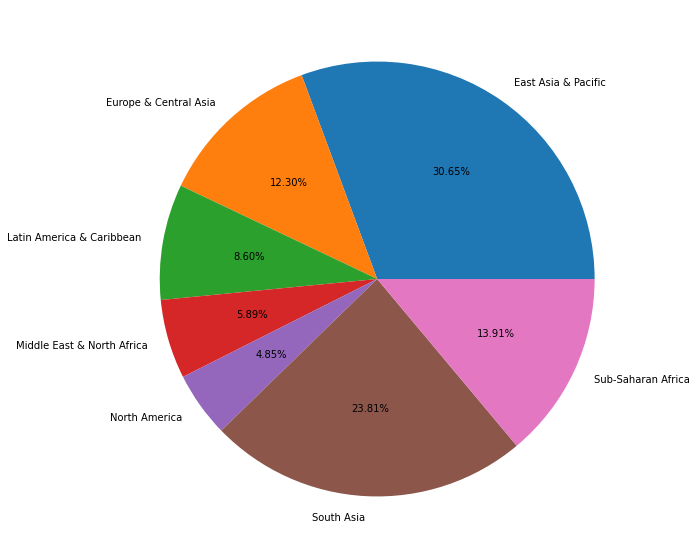

In [ ]:
def population_diagram(dFrame, by, column):
    dFrame.groupby(by)[column].sum().plot(kind='pie', figsize=(10,10), autopct='%1.2f%%')
    pyp.ylabel(' ')
    pyp.show()

population_diagram(dFrame, 'Region', 'Population')

## **Додаткове завдання**

Встановлюємо geopandas до google colab

In [88]:
!pip install geopandas

Спочатку імпортуємо бібліотеки, яка потрібна для завантаження зображень.

In [ ]:
import matplotlib.image as im
import geopy.distance as gd
import geopandas as gp
import numpy as n
import math

Імпортуємо до google colab зображення 'Ukraine.jpg' та файл 'ukr_plata.csv'.

In [ ]:
uploaded_img = files.upload()
uploaded = files.upload()

Saving Ukraine.jpg to Ukraine (1).jpg


Saving ukr_plata.csv to ukr_plata (1).csv


### 1. Завантаження карти україни Ukraine.jpg

In [ ]:
def read_img(path):
    return im.imread(io.BytesIO(uploaded_img[path]), format='jpg')
    #in regular python script we would use:
    #return im.imread(path)

ua_img = read_img('Ukraine.jpg')

### 2.    Розміщення бульбашок, що відповідають населенню 5 довільних міст

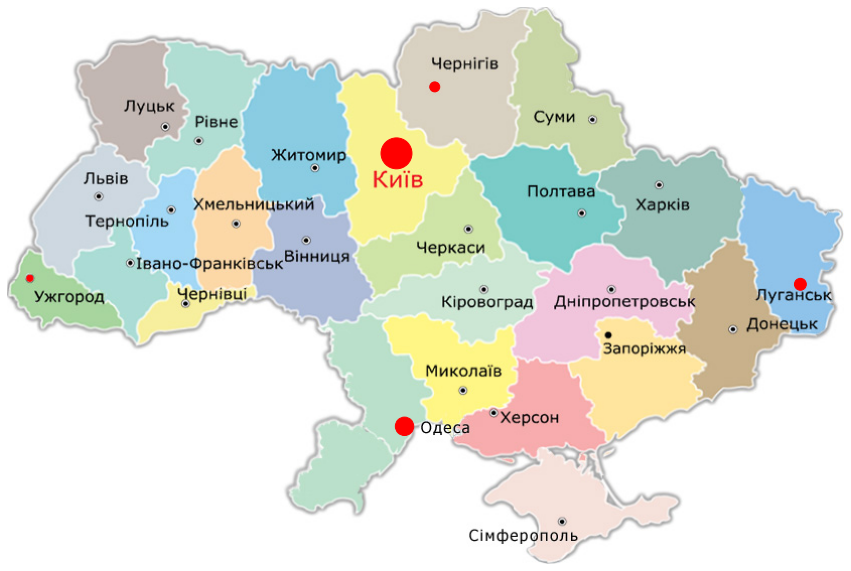

In [ ]:
def c_scatter(ua_img, c_cords, c_pops):
    pyp.figure(figsize=(15, 15))
    pyp.axis('off')
    pyp.imshow(ua_img)
    pyp.scatter(c_cords[:, 0], c_cords[:, 1], s = c_pops / 3000, c = 'red')
    pyp.show()

c_scatter(ua_img, \
          n.array([(22, 269), (787, 275), (394, 416), (424, 79), (386, 145)]), \
          n.array([115500, 424113, 1017022, 295670, 2868702]))

### 3.    Знаходження найбільшої відстані між містами в пікселях та кілометрах

In [ ]:
def biggest_dist_c(c_cords, c_names):
    c_lat_lon = read_dataset('ukr_plata.csv', ',', 'cp1251')
    our_lat_lon = c_lat_lon[c_lat_lon['city'].isin(c_names)]
    find_biggest_dist_km(our_lat_lon)
    find_biggest_dist_corrds(c_cords)

def find_biggest_dist_km(our_lat_lon):
    our_lat_lon = our_lat_lon.reset_index()
    max_dist = -1
    max_index_i = 0
    max_index_j = 0
    for index, row in our_lat_lon.iterrows():
        for index2, row2 in our_lat_lon.iterrows():
            dist = gd.geodesic((row['Lat'], row['Lon']), \
                               (row2['Lat'], row2['Lon'])).km
            if max_dist < dist:
                max_dist = dist
                max_index_i = index
                max_index_j = index2
    print('Найбільша відстань між містами {0} та {1}' \
          .format(our_lat_lon['city'][max_index_i], our_lat_lon['city'][max_index_j]))
    print('Відстань в км: ', round(max_dist, 4))

def find_biggest_dist_corrds(c_coords):
    max_dist = -1
    for coord in c_coords:
        for coord2 in c_coords:
            dist = math.sqrt((coord[0] - coord2[0])**2 + (coord[1] - coord2[1])**2)
            if max_dist < dist:
                max_dist = dist
    print('Відстань в пікселях: ', round(max_dist, 4))

biggest_dist_c(n.array([(22, 269), (787, 275), (394, 416), (424, 79), (386, 145)]), \
               ['Ужгород', 'Луганськ', 'Одеса', 'Чернігів', 'Київ'])

Найбільша відстань між містами Ужгород та Луганськ
Відстань в км:  1250.8148
Відстань в пікселях:  765.0235


### 4. Завантажити shape-файл с областями України.

Імпортуємо до google colab зображення 'Ukraine.jpg' та файл 'ukr_plata.csv'.

In [ ]:
uploaded_shp = files.upload()
uploaded_dpp = files.upload()
uploaded_gdp = files.upload()

Saving UKR_ADM1.shp.zip to UKR_ADM1.shp (2).zip


Saving ukr_DPP.csv to ukr_DPP.csv


Saving ukr_GDP.csv to ukr_GDP.csv


Завантаження shape-файла та датасетів з інформацією

In [ ]:
u_shp = gp.read_file(io.BytesIO(uploaded_shp['UKR_ADM1.shp.zip']))
dpp =  p.read_csv(io.BytesIO(uploaded_dpp['ukr_DPP.csv']), encoding='cp1251', sep=';', decimal=',', header=1)
gdp = p.read_csv(io.BytesIO(uploaded_gdp['ukr_GDP.csv']), encoding='cp1251', sep=';', decimal=',', header=1)

### 5. Побудуватння картограм для прибутку населення на 1 особу і ВВП по регіонам за 2016 рік

Картограма прибутку населення на 1 особу за 2016 рік.

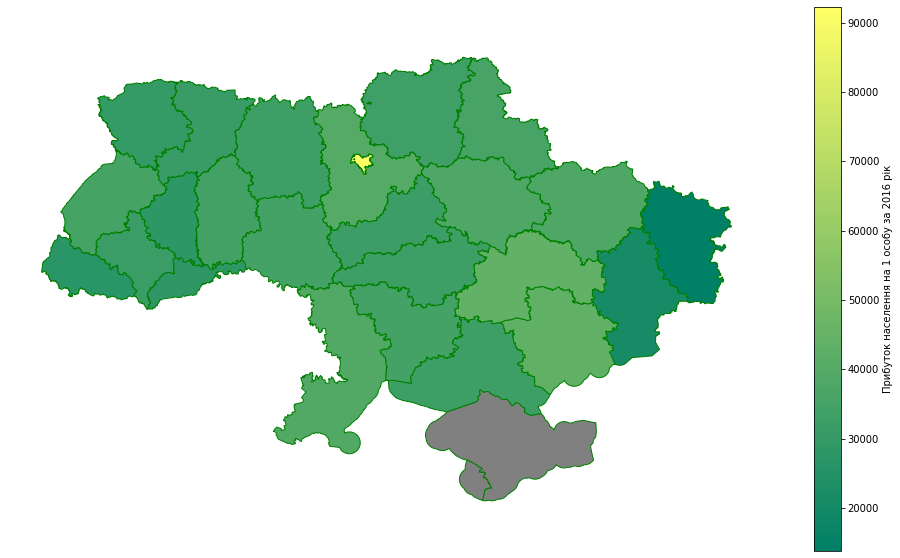

In [ ]:
def draw_dpp_map_2016(u_shp, dpp):
    dpp_map = gp.GeoDataFrame(u_shp.merge(dpp, on = ['Name']))
    dpp_map.plot(column = '2016', \
                 legend = True, \
                 legend_kwds = {'label': "Прибуток населення на 1 особу за 2016 рік"}, \
                 missing_kwds = {"color": "gray"}, \
                 figsize = (17, 10), \
                 cmap = 'summer', \
                 edgecolor = 'green')
    pyp.axis('off')
    pyp.show()

draw_dpp_map_2016(u_shp, dpp)

Картограма ВВП по регіонам за 2016 рік.

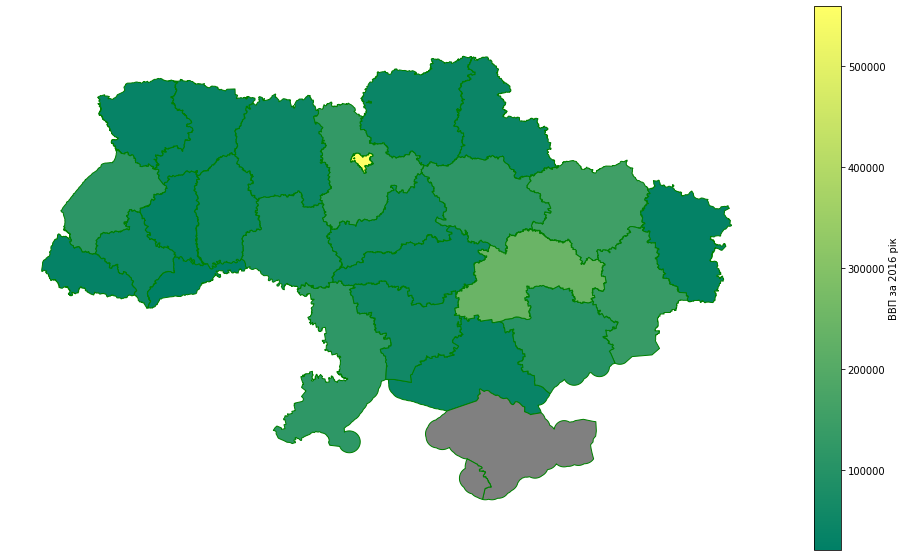

In [ ]:
def draw_gdp_map_2016(u_shp, gdp):
    gdp_map = gp.GeoDataFrame(u_shp.merge(gdp, on = ['Name']))
    gdp_map.plot(column='2016', \
                 legend=True, \
                 legend_kwds={'label': "ВВП за 2016 рік"}, \
                 missing_kwds = {"color": "gray"}, \
                 figsize=(17, 10), \
                 cmap='summer', \
                 edgecolor='green')
    pyp.axis('off')
    pyp.show()

draw_gdp_map_2016(u_shp, gdp)

### 6. Розрахунок коефіцієнтів кореляції між прибутком населення на 1 особу та ВВП
(+ відображення на картограммі)


Розрахунок коефіцієнтів кореляції.

In [89]:
def cor_calculate(first, second, names):
    correlations = p.DataFrame();
    correlations['correlation'] = first.corrwith(second, axis = 1)
    correlations['Name'] = names
    return correlations

cor = cor_calculate(dpp.iloc[: , 6:], gdp.iloc[: , 6:], gdp['Name'])
print(cor)

    correlation                           Name
0      1.000000  Autonomous Republic of Crimea
1      0.988787               Vinnytsia Oblast
2      0.971714                   Volyn Oblast
3      0.993466          Dnipropetrovsk Oblast
4      0.761617                 Donetsk Oblast
5      0.990027                Zhytomyr Oblast
6      0.960397             Zakarpattia Oblast
7      0.986106              Zaporizhia Oblast
8      0.958761         Ivano-Frankivsk Oblast
9      0.995409                    Kyiv Oblast
10     0.984216              Kirovohrad Oblast
11     0.888108                 Luhansk Oblast
12     0.991438                    Lviv Oblast
13     0.982533                Mykolaiv Oblast
14     0.988180                  Odessa Oblast
15     0.990836                 Poltava Oblast
16     0.954661                   Rivne Oblast
17     0.977953                    Sumy Oblast
18     0.953316                Ternopil Oblast
19     0.992241                 Kharkiv Oblast
20     0.9842

Відображення коефцієнтів кореляції на картограммі.

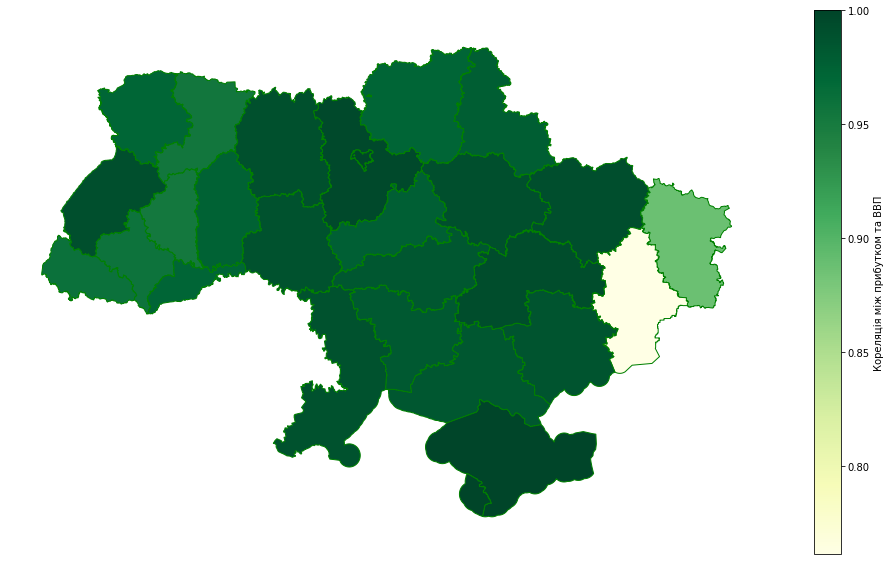

In [ ]:
def draw_cor_map(u_shp, cor):
    cor_map = p.merge(u_shp, cor, on=['Name'])
    cor_map.plot(column = 'correlation', \
                 legend = True, \
                 legend_kwds = {'label': 'Кореляція між прибутком та ВВП'}, \
                 missing_kwds = {'color': 'gray'}, \
                 figsize = (17, 10), \
                 cmap = 'YlGn', \
                 edgecolor = 'green')
    pyp.axis('off')
    pyp.show()

draw_cor_map(u_shp, cor)